## Imports

### Modules and Packages

In [57]:
import re
import math
import time
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import sqlite3
import imaplib as imap

### Files

In [9]:
# Import valid (actually used) zip codes
places_df = pd.read_excel("https://www.bfs.admin.ch/bfsstatic/dam/assets/275785/master", sheetname = "Ortschaftenverz.-Rép. Localités", encoding = "utf-8")
zip_codes_pd = places_df["PLZ4"].tolist()
zip_codes_list = list(set(zip_codes_pd))
zip_codes = [str(x) for x in sorted(zip_codes_list)]

## Functions

In [10]:
# Check if there is any digit in a string
def any_digit(string):
    return any(i.isdigit() for i in string)

# Check if a string contains at least two substrings from a list
def at_least_n_strings_in_longstring(strings, longstring, n = 2):
    strings = iter(strings)
    return all(any(string in longstring for string in strings) for _ in range(n))

def html_to_soup(url):
    r = requests.get(url)
    html_content = r.text
    soup = BeautifulSoup(html_content, 'lxml')
    return(soup)
    
def replace_umlaute(some_list):
    addr_out = some_list.replace("ü", "ue")
    addr_out = addr_out.replace("ä", "ae")
    addr_out = addr_out.replace("ö", "oe")
    return(addr_out)

def set_none(list_vars):
    for var in list_vars:
        var = None
        
BASE_URL = "https://www.comparis.ch"

def get_category_links(section_url):
    html = urlopen(section_url).read()
    soup = BeautifulSoup(html, "lxml")
    boccat = soup.find("a", "title")
    category_links = [BASE_URL + dd.a["href"] for dd in boccat.findAll("dd")]
    return category_links

## MySQL Database

In [228]:
db_name = "zurich_coord"
conn = sqlite3.connect(db_name + '.db')
conn.execute("DROP TABLE IF EXISTS COMPARIS")

conn.execute('''CREATE TABLE COMPARIS
       (STREET           TEXT,
       LONGITUDE INT,
       LATITUDE INT,
       ZIP          TEXT,
       CITY varchar(64),
       TYPE           TEXT,
       PRICE1 INT,
       PRICE2        INT,
       SPACE INT,
       ROOMS INT,
       FLOOR INT,
       AVAILABILITY INT,
       FIRE_PLACE INT,
       LIFT INT,
       BALCONY INT,
       WHEEL_CHAIR INT,
       PARKING INT,
       MINERGIE INT,
       DESCRPT TEXT,
       SOURCE TEXT,
       DATE_FOUND TEXT,
       DATE_SCRAPED TEXT);''')

conn.close()

## Web Scraping

In [206]:
zip_codes = [str(x) for x in range(8001, 8064)]
conn = sqlite3.connect(db_name + '.db')
cur = conn.cursor()
# Zip-Codes Loop
for zip_code in zip_codes:
    print(zip_code)
    try:
        url_city = 'https://www.comparis.ch/immobilien/result/list?requestobject={%22DealType%22:%2210%22,%22SiteId%22:%220%22,%22RootPropertyTypes%22:[%221%22],%22PropertyTypes%22:[],%22RoomsFrom%22:null,%22RoomsFrom%22:null,%22RoomsTo%22:null,%22FloorSearchType%22:%220%22,%22LivingSpaceFrom%22:null,%22LivingSpaceTo%22:null,%22PriceFrom%22:null,%22PriceTo%22:null,%22ComparisPointsMin%22:%220%22,%22AdAgeMax%22:%220%22,%22AdAgeInHoursMax%22:null,%22Keyword%22:%22%22,%22WithImagesOnly%22:false,%22WithPointsOnly%22:null,%22Radius%22:null,%22MinAvailableDate%22:null,%22MinChangeDate%22:%221753-01-01T00:00:00%22,%22LocationSearchString%22:%22' + zip_code + '%22,%22Sort%22:%226%22,%22HasBalcony%22:false,%22HasTerrace%22:false,%22HasFireplace%22:false,%22HasDishwasher%22:false,%22HasWashingMachine%22:false,%22HasLift%22:false,%22HasParking%22:false,%22PetsAllowed%22:false,%22MinergieCertified%22:false,%22WheelchairAccessible%22:false,%22LowerLeftLatitude%22:null,%22LowerLeftLongitude%22:null,%22UpperRightLatitude%22:null,%22UpperRightLongitude%22:null}&sort=6&page=0'
        soup_city = html_to_soup(url_city)
        results_string = soup_city.find('div', {'class': 'hide-for-xsmall show-for-small'}).text.replace("'", "")
        results_string
        nr_results = float(re.findall(r'\d+', results_string)[0])
        nr_pages = math.ceil(int(nr_results)/10)
        for j in range(0, min(nr_pages, 99)):
            print(j)
            url_pages = url_city.replace("page=0", "page=" + str(j))
            soup_pages = html_to_soup(url_pages)
            objects = soup_pages.find_all('a', {'class': 'title', 'href': True})
            for obj in objects:
                start = time.time()
                url_obj = "https://www.comparis.ch" + obj['href']
                soup_obj = html_to_soup(url_obj)
                address = soup_obj.find('h3', {'class': 'text-green'})
                try:
                    address_list = address.string.split(",")
                except AttributeError:
                    continue
                
                date_today = time.strftime("%d/%m/%Y")
                date_today_time = time.strptime(date_today,  "%d/%m/%Y")
                date_found_str = soup_obj.find("ul", {"class": "meta-tag-line"})
                li_all = date_found_str.find_all("li")
                if len(li_all) == 1:
                    li = li_all[0].text
                else:
                    li = li_all[1].text
                date_found_str2 = ".".join(re.findall(r'\d+', li))
                date_found_time = time.strptime(date_found_str2, "%d.%m.%Y")
                city_name = None
                if len(address_list) == 2:
                    street = address_list[0]
                    print(street)
                    zip_code_di = re.findall(r'\d+', address_list[1])[0]
                    if zip_code_di == zip_code:
                        city_name_ex = re.findall(r'[A-Za-z_ÄäÖöÜüÀàÂâÇçÈèÉéÊêÎîÔôÛû_\-]+', address_list[1].strip())
                        if city_name_ex  != []:
                            city_name = city_name_ex[0]
                        print(city_name)
                        key_data = soup_obj.find(class_= 'row xsmall-up-2 medium-up-3 large-up-4 attributes-grid')
                        key_data2 = key_data.find_all(['dt', 'dd'])
                        price = None
                        price_nk = None
                        liv_space = None
                        rooms = None
                        flr = None
                        avail = None
                        aux_var = None
                        lift = 0
                        balcony = 0
                        wheel_chair = 0
                        parking = 0
                        minergie = 0
                        fire_place = 0
                        source = None
                        for key in key_data2:
                            val = key.text.strip()
                            if aux_var == "Objektart":
                                kind = val
                            elif aux_var and any(substr in aux_var.lower() for substr in ['preis', 'monat']) and "m2" not in aux_var.lower():
                                price_str = re.findall(r'\d+', val.replace("'", ""))
                                if at_least_n_strings_in_longstring(['nebenkosten', 'nk', 'preis'], aux_var.lower(), 2):
                                    if any_digit(val):
                                        price_nk = float(price_str[0])
                                else:
                                    if any_digit(val):
                                        price = float(price_str[0]) 
                            elif aux_var and "wohnfläche" in aux_var.lower():
                                liv_space_str = re.findall(r'\d+', val.replace("m²", ""))
                                liv_space = float(liv_space_str[0])
                            elif aux_var and "zimmer" in aux_var.lower() and not any(substr in aux_var.lower() for substr in ['wg', 'einzelzimmer']):
                                rooms_str = val.replace("½", ".5")
                                rooms = float(rooms_str)
                            elif aux_var and any(substr in aux_var.lower() for substr in ['geschoss', 'etage', 'stockwerk']):
                                if any_digit(val):
                                    flr = float(re.findall(r'\d+', val)[0])
                                elif val == "EG":
                                    flr = 0
                                else:
                                    flr = val
                            elif aux_var and "verfügbar" in aux_var.lower():
                                avail = val
                            elif aux_var and any(substr in aux_var.lower() for substr in ['cheminée', 'kamin']):
                                fire_place = 1
                            elif aux_var and "lift" in aux_var.lower():
                                lift = 1
                            elif aux_var and any(substr in aux_var.lower() for substr in ['balkon', 'terasse']):
                                balcony = 1
                            elif aux_var and "rollstuhl" in aux_var.lower():
                                wheel_chair = 1
                            elif aux_var and "parkplatz" in aux_var.lower():
                                parking = 1
                            elif aux_var and "minergie" in aux_var.lower():
                                minergie = 1
                            descrp = soup_obj.find("div", {"id": "div_Description"})
                            if descrp:
                                descrp_text = descrp.text
                            aux_var = val    
                        source_soup = soup_obj.find('a', {'class': 'follow-link'})
                        if source_soup:
                            source = source_soup.string
                        cur.execute('''INSERT INTO COMPARIS(STREET, ZIP, CITY, TYPE, PRICE1, PRICE2, SPACE, ROOMS, FLOOR, AVAILABILITY, FIRE_PLACE, LIFT, BALCONY, WHEEL_CHAIR, PARKING, MINERGIE,  DESCRPT, SOURCE, DATE_FOUND, DATE_SCRAPED)VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''', (street, zip_code, city_name, kind, price, price_nk, liv_space, rooms, flr, avail, fire_place, lift, balcony, wheel_chair, parking, minergie, descrp_text, source, date_found_str2, date_today))
                    else:
                        raise StopIteration
    except StopIteration: pass
print("commit")
conn.commit()
conn.close() 

    
# ACHTUNG SOURCE and DATE_SCRAPED

8001
0
St. Peterhofstatt 10
Zürich
Hirschengraben
Zürich
Glockengasse 9
Zürich
Limmatquai 106
Zürich
A Zähringerstr. 9
Zürich
A Zähringerstr. 9
Zürich
Zähringerstrasse 9
Zürich
Fortunagasse 15
Zürich
Predigerplatz
Zürich
1
Bahnhofstrasse 89
Zürich
Strehlgasse 20
Zürich
Stadelhoferstrasse 28
Zürich
Weggengasse 6
Zürich
Neustadtgasse 11
Zürich


KeyboardInterrupt: 

In [207]:
conn.close() 

In [84]:
html_to_soup(url_city)

<!DOCTYPE html>
<html lang="De">
<head>
<title>Immobilien mieten in Lausanne - Mieten vergleichen mit comparis.ch</title>
<meta content="noindex,nofollow" name="robots"/>
<meta content="Lausanne, wohnung, mieten, immobilien, mietwohnung, haus, zimmerwohnung, einfamilienhaus, altbauwohnung, eigentumswohnung, dachwohnung, maisonettenwohnung, attikawohnung" name="keywords"/>
<meta content="Alle Immobilien suchen  in Lausanne ganz einfach mit comparis.ch. Alle Immobilien zur Miete verschiedener Immobilienportale auf einen Blick mit Angaben zum Sparpotenzial." name="description"/>
<meta content="comparis.ch AG" name="copyright"/>
<meta content="de" http-equiv="Content-Language"/>
<meta content="de" name="language"/>
<meta content="private" http-equiv="Cache-Control"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="utf-8" property="charset"/>
<meta content="VoCfOaTipeb2lm/zZFAgL3o9OwS2WyFOo3YbjnUKMnU=" name="verify-v1"/>
<meta content="f8428b8355306eb5" name="y_key"/>


In [97]:
soup_city.find('div', {'class': 'hide-for-xsmall show-for-small'}).text


"4'657 Treffer auf allen grossen Schweizer Immobilienmarktplätzen"

In [89]:
soup_city

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
<head>
<meta content="300" http-equiv="Refresh"/>
<meta content="no-cache" http-equiv="Pragma"/>
<meta content="no-cache" http-equiv="Cache-Control"/>
<meta content="&lt;%=now%&gt;" http-equiv="Expires"/>
<meta content="HTTP Error" http-equiv="Generator"/>
<meta content="&lt;%=now%&gt;" http-equiv="Date"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
</head>
<body bgcolor="#66CC00" text="#FFFFFF">
<table border="0" cellpadding="50" id="Table1" width="100%">
<tr>
<td>
<font face="arial, helvetica"><img alt="comparis.ch AG - Das Leben wird einfacher" border="0" height="84" src="/logo.gif" width="283"/>
<h3>Liebe Besucherin, lieber Besucher</h3>
<p>
							Es tut uns leid, dass Sie im Moment nicht auf die Vergleiche und Dienstleistungen von comparis.ch zugreifen können. 
							Bitte versuchen Sie es in wenigen Minuten nochmals.<br/>
<br/>
							Besten Dank für Ihr Verständnis.<br/>
<br/>
						

In [93]:
        url_city = 'https://www.comparis.ch/immobilien/result/list?requestobject={%22DealType%22:%2210%22,%22SiteId%22:%220%22,%22RootPropertyTypes%22:[],%22PropertyTypes%22:[],%22RoomsFrom%22:null,%22RoomsTo%22:null,%22FloorSearchType%22:%220%22,%22LivingSpaceFrom%22:null,%22LivingSpaceTo%22:null,%22PriceFrom%22:null,%22PriceTo%22:null,%22ComparisPointsMin%22:%220%22,%22AdAgeMax%22:%220%22,%22AdAgeInHoursMax%22:null,%22Keyword%22:%22%22,%22WithImagesOnly%22:false,%22WithPointsOnly%22:null,%22Radius%22:null,%22MinAvailableDate%22:null,%22MinChangeDate%22:%221753-01-01T00:00:00%22,%22LocationSearchString%22:%228000%22,%22Sort%22:%226%22,%22HasBalcony%22:false,%22HasTerrace%22:false,%22HasFireplace%22:false,%22HasDishwasher%22:false,%22HasWashingMachine%22:false,%22HasLift%22:false,%22HasParking%22:false,%22PetsAllowed%22:false,%22MinergieCertified%22:false,%22WheelchairAccessible%22:false,%22LowerLeftLatitude%22:null,%22LowerLeftLongitude%22:null,%22UpperRightLatitude%22:null,%22UpperRightLongitude%22:null}&sort=6&page=0'
        soup_city = html_to_soup(url_city)
        print(soup_city)
        results_string = soup_city.find('div', {'class': 'hide-for-xsmall show-for-small'})

<!DOCTYPE html>
<html lang="De">
<head>
<title>Immobilien mieten in Zürich - Mieten vergleichen mit comparis.ch</title>
<meta content="noindex,nofollow" name="robots"/>
<meta content="Zürich, wohnung, mieten, immobilien, mietwohnung, haus, zimmerwohnung, einfamilienhaus, altbauwohnung, eigentumswohnung, dachwohnung, maisonettenwohnung, attikawohnung" name="keywords"/>
<meta content="Alle Immobilien suchen  in Zürich ganz einfach mit comparis.ch. Alle Immobilien zur Miete verschiedener Immobilienportale auf einen Blick mit Angaben zum Sparpotenzial." name="description"/>
<meta content="comparis.ch AG" name="copyright"/>
<meta content="de" http-equiv="Content-Language"/>
<meta content="de" name="language"/>
<meta content="private" http-equiv="Cache-Control"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="utf-8" property="charset"/>
<meta content="VoCfOaTipeb2lm/zZFAgL3o9OwS2WyFOo3YbjnUKMnU=" name="verify-v1"/>
<meta content="f8428b8355306eb5" name="y_key"/>
<meta 

In [151]:

address_list[1].strip()
test = replace_umlaute(address_list[1].strip())
re.findall(r'[A-Za-z_ÄäÖöÜüÀàÂâÇçÈèÉéÊêÎîÔôÛû]+', test)

['Genève']

In [152]:
re.findall(r'[A-Za-z_ÄäÖöÜüÀàÂâÇçÈèÉéÊêÎîÔôÛû_\-]+', 'Aigle-sur-lac')

['Aigle-sur-lac']

In [161]:
zip_codes = [str(x) for x in range(1000, 9658)]
zip_codes

['1000',
 '1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1006',
 '1007',
 '1008',
 '1009',
 '1010',
 '1011',
 '1012',
 '1013',
 '1014',
 '1015',
 '1016',
 '1017',
 '1018',
 '1019',
 '1020',
 '1021',
 '1022',
 '1023',
 '1024',
 '1025',
 '1026',
 '1027',
 '1028',
 '1029',
 '1030',
 '1031',
 '1032',
 '1033',
 '1034',
 '1035',
 '1036',
 '1037',
 '1038',
 '1039',
 '1040',
 '1041',
 '1042',
 '1043',
 '1044',
 '1045',
 '1046',
 '1047',
 '1048',
 '1049',
 '1050',
 '1051',
 '1052',
 '1053',
 '1054',
 '1055',
 '1056',
 '1057',
 '1058',
 '1059',
 '1060',
 '1061',
 '1062',
 '1063',
 '1064',
 '1065',
 '1066',
 '1067',
 '1068',
 '1069',
 '1070',
 '1071',
 '1072',
 '1073',
 '1074',
 '1075',
 '1076',
 '1077',
 '1078',
 '1079',
 '1080',
 '1081',
 '1082',
 '1083',
 '1084',
 '1085',
 '1086',
 '1087',
 '1088',
 '1089',
 '1090',
 '1091',
 '1092',
 '1093',
 '1094',
 '1095',
 '1096',
 '1097',
 '1098',
 '1099',
 '1100',
 '1101',
 '1102',
 '1103',
 '1104',
 '1105',
 '1106',
 '1107',
 '1108',
 '1109',
 '1110',
 

In [164]:
a = None
b = None

def assign_keys(argument):
    switcher = {
        "d": a = argument,
        "e": b = arguments
    }
    return switcher.get(argument, "nothing")

SyntaxError: invalid syntax (<ipython-input-164-d5695b141a8f>, line 6)

In [196]:
db_name = "garbage"
conn = sqlite3.connect(db_name + '.db')
conn.execute("DROP TABLE IF EXISTS TABLEX")

conn.execute('''CREATE TABLE TABLEX
       (ITERATION INT);''')

conn.close()

In [197]:
conn = sqlite3.connect(db_name + '.db')
cur = conn.cursor()

for i in range(0, 10):
    cur.execute('''insert into TABLEX(ITERATION) values(?)''', (i,))
conn.commit()
cur.close()
conn.close()

In [201]:
conn = sqlite3.connect(db_name + '.db')
cur.execute("select * from tablex;")
results = cur.fetchall()
print(results)

[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)]


In [2]:
BASE_URL = "https://www.comparis.ch"

def get_category_links(section_url):
    html = urlopen(section_url).read()
    soup = BeautifulSoup(html, "lxml")
    boccat = soup.find("a", "title")

NameError: name 'html_to_soup' is not defined

In [10]:
from urllib3 import urlopen
url_pages = 'https://www.comparis.ch/immobilien/result/list?requestobject={%22DealType%22:%2210%22,%22SiteId%22:%220%22,%22RootPropertyTypes%22:[%221%22],%22PropertyTypes%22:[],%22RoomsFrom%22:null,%22RoomsFrom%22:null,%22RoomsTo%22:null,%22FloorSearchType%22:%220%22,%22LivingSpaceFrom%22:null,%22LivingSpaceTo%22:null,%22PriceFrom%22:null,%22PriceTo%22:null,%22ComparisPointsMin%22:%220%22,%22AdAgeMax%22:%220%22,%22AdAgeInHoursMax%22:null,%22Keyword%22:%22%22,%22WithImagesOnly%22:false,%22WithPointsOnly%22:null,%22Radius%22:null,%22MinAvailableDate%22:null,%22MinChangeDate%22:%221753-01-01T00:00:00%22,%22LocationSearchString%22:%22' + '8000' + '%22,%22Sort%22:%226%22,%22HasBalcony%22:false,%22HasTerrace%22:false,%22HasFireplace%22:false,%22HasDishwasher%22:false,%22HasWashingMachine%22:false,%22HasLift%22:false,%22HasParking%22:false,%22PetsAllowed%22:false,%22MinergieCertified%22:false,%22WheelchairAccessible%22:false,%22LowerLeftLatitude%22:null,%22LowerLeftLongitude%22:null,%22UpperRightLatitude%22:null,%22UpperRightLongitude%22:null}&sort=6&page=0'
html = urlopen(url_pages).read()
soup = BeautifulSoup(html, "lxml")
soup

ImportError: cannot import name 'urlopen'

In [33]:

url_obj = "https://www.comparis.ch" + obj['href'] + '#map'
url_obj

'https://www.comparis.ch/immobilien/marktplatz/details/show/16669748#map'

<!DOCTYPE html>
<html lang="De">
<head>
<title>3½ Zimmer Wohnung in 8004 Zürich  – Immobilienmarkt von comparis.ch</title>
<meta content="noindex,nofollow" name="robots"/>
<meta content="Wohnung, 3½ Zimmer Wohnung, Miete, 8004 Zürich " name="keywords"/>
<meta content="3½ Zimmer Wohnung in 8004 Zürich , Mietpreis / Monat 2090 CHF  , Balkon" name="description"/>
<meta content="comparis.ch AG" name="copyright"/>
<meta content="de" http-equiv="Content-Language"/>
<meta content="de" name="language"/>
<meta content="private" http-equiv="Cache-Control"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="utf-8" property="charset"/>
<meta content="VoCfOaTipeb2lm/zZFAgL3o9OwS2WyFOo3YbjnUKMnU=" name="verify-v1"/>
<meta content="f8428b8355306eb5" name="y_key"/>
<meta content="7F06A1DE4D8C6ED8AB24B3A1EA7356B7" name="msvalidate.01"/>
<meta content="Ii9L6UhICzdiSmdfNdVK7YJcm1zs3N9laDUpNAXGUPs" name="google-site-verification"/>
<meta content='{"exception": {"Enable": false}, "remot
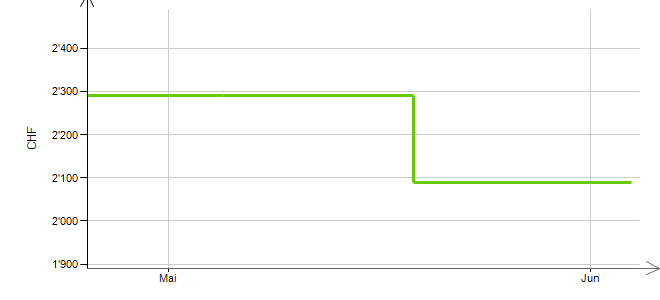

In [32]:
soup_obj = html_to_soup(url_obj)
soup_obj

In [18]:
from selenium import webdriver
import time
 
driver.get('http://codepad.org')

#dr.get("https://www.comparis.ch/immobilien/marktplatz/details/show/16669748")


NameError: name 'driver' is not defined

In [49]:
from selenium import webdriver
 
driver = webdriver.Chrome()

In [58]:
driver.get("https://www.comparis.ch/immobilien/marktplatz/details/show/16844082")

In [51]:
test = driver.find_element_by_link_text('Karte').click()


In [52]:
html = driver.page_source

In [54]:
soup_obj = BeautifulSoup(html)

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [62]:
driver.get(url_obj)
driver.find_element_by_link_text('Karte').click()
html = driver.page_source
soup_obj = BeautifulSoup(html)

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [64]:
soup_obj.find('h3', {'class': 'text-green'})

<h3 class="text-green">Agnesstr. 53, 8004 Zürich</h3>

In [230]:
zip_codes = [str(x) for x in range(8001, 8064)]
conn = sqlite3.connect(db_name + '.db')
cur = conn.cursor()
driver = webdriver.Chrome()
# Zip-Codes Loop
for zip_code in zip_codes:
    print(zip_code)
    try:
        url_city = 'https://www.comparis.ch/immobilien/result/list?requestobject={%22DealType%22:%2210%22,%22SiteId%22:%220%22,%22RootPropertyTypes%22:[%221%22],%22PropertyTypes%22:[],%22RoomsFrom%22:null,%22RoomsFrom%22:null,%22RoomsTo%22:null,%22FloorSearchType%22:%220%22,%22LivingSpaceFrom%22:null,%22LivingSpaceTo%22:null,%22PriceFrom%22:null,%22PriceTo%22:null,%22ComparisPointsMin%22:%220%22,%22AdAgeMax%22:%220%22,%22AdAgeInHoursMax%22:null,%22Keyword%22:%22%22,%22WithImagesOnly%22:false,%22WithPointsOnly%22:null,%22Radius%22:null,%22MinAvailableDate%22:null,%22MinChangeDate%22:%221753-01-01T00:00:00%22,%22LocationSearchString%22:%22' + zip_code + '%22,%22Sort%22:%226%22,%22HasBalcony%22:false,%22HasTerrace%22:false,%22HasFireplace%22:false,%22HasDishwasher%22:false,%22HasWashingMachine%22:false,%22HasLift%22:false,%22HasParking%22:false,%22PetsAllowed%22:false,%22MinergieCertified%22:false,%22WheelchairAccessible%22:false,%22LowerLeftLatitude%22:null,%22LowerLeftLongitude%22:null,%22UpperRightLatitude%22:null,%22UpperRightLongitude%22:null}&sort=6&page=0'
        soup_city = html_to_soup(url_city)
        results_string = soup_city.find('div', {'class': 'hide-for-xsmall show-for-small'}).text.replace("'", "")
        results_string
        nr_results = float(re.findall(r'\d+', results_string)[0])
        nr_pages = math.ceil(int(nr_results)/10)
        for j in range(0, min(nr_pages, 99)):
            print(j)
            url_pages = url_city.replace("page=0", "page=" + str(j))
            soup_pages = html_to_soup(url_pages)
            objects = soup_pages.find_all('a', {'class': 'title', 'href': True})
            for obj in objects:
                start = time.time()
                url_obj = "https://www.comparis.ch" + obj['href']
                driver = webdriver.Chrome()
                driver.get(url_obj)
                #driver.find_element_by_link_text('Karte').click()
                wait = WebDriverWait(driver, 10)
                wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="map"]/div/div[1]')))
                html = driver.page_source
                soup_obj = BeautifulSoup(html, "lxml")
                text_map = soup_obj.find('div', {'id': 'map'})
                longitude = float(re.findall('"([^"]*)"', str(text_map))[7])
                latitude = float(re.findall('"([^"]*)"', str(text_map))[6])
                print(longitude, latitude)
                address = soup_obj.find('h3', {'class': 'text-green'})
                try:
                    address_list = address.string.split(",")
                except AttributeError:
                    continue
                
                date_today = time.strftime("%d/%m/%Y")
                date_today_time = time.strptime(date_today,  "%d/%m/%Y")
                date_found_str = soup_obj.find("ul", {"class": "meta-tag-line"})
                li_all = date_found_str.find_all("li")
                if len(li_all) == 1:
                    li = li_all[0].text
                else:
                    li = li_all[1].text
                date_found_str2 = ".".join(re.findall(r'\d+', li))
                date_found_time = time.strptime(date_found_str2, "%d.%m.%Y")
                city_name = None
                if len(address_list) == 2:
                    street = address_list[0]
                    print(street)
                    zip_code_di = re.findall(r'\d+', address_list[1])[0]
                    if zip_code_di == zip_code:
                        city_name_ex = re.findall(r'[A-Za-z_ÄäÖöÜüÀàÂâÇçÈèÉéÊêÎîÔôÛû_\-]+', address_list[1].strip())
                        if city_name_ex  != []:
                            city_name = city_name_ex[0]
                        print(city_name)
                        key_data = soup_obj.find(class_= 'row xsmall-up-2 medium-up-3 large-up-4 attributes-grid')
                        key_data2 = key_data.find_all(['dt', 'dd'])
                        price = None
                        price_nk = None
                        liv_space = None
                        rooms = None
                        flr = None
                        avail = None
                        aux_var = None
                        lift = 0
                        balcony = 0
                        wheel_chair = 0
                        parking = 0
                        minergie = 0
                        fire_place = 0
                        source = None
                        for key in key_data2:
                            val = key.text.strip()
                            if aux_var == "Objektart":
                                kind = val
                            elif aux_var and any(substr in aux_var.lower() for substr in ['preis', 'monat']) and "m2" not in aux_var.lower():
                                price_str = re.findall(r'\d+', val.replace("'", ""))
                                if at_least_n_strings_in_longstring(['nebenkosten', 'nk', 'preis'], aux_var.lower(), 2):
                                    if any_digit(val):
                                        price_nk = float(price_str[0])
                                else:
                                    if any_digit(val):
                                        price = float(price_str[0]) 
                            elif aux_var and "wohnfläche" in aux_var.lower():
                                liv_space_str = re.findall(r'\d+', val.replace("m²", ""))
                                liv_space = float(liv_space_str[0])
                            elif aux_var and "zimmer" in aux_var.lower() and not any(substr in aux_var.lower() for substr in ['wg', 'einzelzimmer']):
                                rooms_str = val.replace("½", ".5")
                                rooms = float(rooms_str)
                            elif aux_var and any(substr in aux_var.lower() for substr in ['geschoss', 'etage', 'stockwerk']):
                                if any_digit(val):
                                    flr = float(re.findall(r'\d+', val)[0])
                                elif val == "EG":
                                    flr = 0
                                else:
                                    flr = val
                            elif aux_var and "verfügbar" in aux_var.lower():
                                avail = val
                            elif aux_var and any(substr in aux_var.lower() for substr in ['cheminée', 'kamin']):
                                fire_place = 1
                            elif aux_var and "lift" in aux_var.lower():
                                lift = 1
                            elif aux_var and any(substr in aux_var.lower() for substr in ['balkon', 'terasse']):
                                balcony = 1
                            elif aux_var and "rollstuhl" in aux_var.lower():
                                wheel_chair = 1
                            elif aux_var and "parkplatz" in aux_var.lower():
                                parking = 1
                            elif aux_var and "minergie" in aux_var.lower():
                                minergie = 1
                            descrp = soup_obj.find("div", {"id": "div_Description"})
                            if descrp:
                                descrp_text = descrp.text
                            aux_var = val    
                        source_soup = soup_obj.find('a', {'class': 'follow-link'})
                        if source_soup:
                            source = source_soup.string
                        cur.execute('''INSERT INTO COMPARIS(STREET, LONGITUDE, LATITUDE, ZIP, CITY, TYPE, PRICE1, PRICE2, SPACE, ROOMS, FLOOR, AVAILABILITY, FIRE_PLACE, LIFT, BALCONY, WHEEL_CHAIR, PARKING, MINERGIE,  DESCRPT, SOURCE, DATE_FOUND, DATE_SCRAPED)VALUES(?,?,?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''', (street, longitude, latitude, zip_code, city_name, kind, price, price_nk, liv_space, rooms, flr, avail, fire_place, lift, balcony, wheel_chair, parking, minergie, descrp_text, source, date_found_str2, date_today))
                    else:
                        raise StopIteration
    except StopIteration: pass
print("commit")
conn.commit()
conn.close() 

    
# ACHTUNG SOURCE and DATE_SCRAPED

8001
0
8.540997049150258 47.37168935152562
St. Peterhofstatt 10
Zürich
8.547059011542197 47.37284570118031
Hirschengraben
Zürich
8.54028570283618 47.3718670454425
Glockengasse 9
Zürich
8.543488812901009 47.375002762610876
Limmatquai 106
Zürich
8.544560816393114 47.37433585776908
A Zähringerstr. 9
Zürich
8.544560816393114 47.37433585776908
A Zähringerstr. 9
Zürich
8.544560816393114 47.37433585776908
Zähringerstrasse 9
Zürich
8.539631039683975 47.374149067011786
8.539781976138126 47.37312217809907
Fortunagasse 15
Zürich
8.545739451374443 47.373703901582346
Predigerplatz
Zürich
1
8.53941601301545 47.37656182256677
Bahnhofstrasse 89
Zürich
8.540929330097935 47.37225669438125
Strehlgasse 20
Zürich
8.54735665821466 47.36741873866204
Stadelhoferstrasse 28
Zürich
8.541113592165312 47.371562306806986
Weggengasse 6
Zürich
8.544867128460169 47.36995226685667
Neustadtgasse 11
Zürich
8.544867128460169 47.36995226685667
Neustadtgasse 11
Zürich
8.540952353742203 47.370808249583696
Schlüsselgasse 3
Zü

In [110]:
driver = webdriver.Chrome()
url_obj = "https://www.comparis.ch" + obj['href']
driver.get(url_obj)
driver.find_element_by_link_text('Karte').click()
html = driver.page_source
soup_obj = BeautifulSoup(html)

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [72]:
soup_obj

<!DOCTYPE html>
<html class="no-touchevents" lang="De" xmlns="http://www.w3.org/1999/xhtml"><head>
<title>5 Zimmer Wohnung in 8001 Zürich  – Immobilienmarkt von comparis.ch</title>
<meta content="noindex,nofollow" name="robots"/>
<meta content="Wohnung, 5 Zimmer Wohnung, Miete, 8001 Zürich " name="keywords"/>
<meta content="5 Zimmer Wohnung in 8001 Zürich , Mietpreis / Monat 8300 CHF  , Balkon, Lift" name="description"/>
<meta content="comparis.ch AG" name="copyright"/>
<meta content="de" http-equiv="Content-Language"/>
<meta content="de" name="language"/>
<meta content="private" http-equiv="Cache-Control"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="utf-8" property="charset"/>
<meta content="VoCfOaTipeb2lm/zZFAgL3o9OwS2WyFOo3YbjnUKMnU=" name="verify-v1"/>
<meta content="f8428b8355306eb5" name="y_key"/>
<meta content="7F06A1DE4D8C6ED8AB24B3A1EA7356B7" name="msvalidate.01"/>
<meta content="Ii9L6UhICzdiSmdfNdVK7YJcm1zs3N9laDUpNAXGUPs" name="google-site-verifica

In [73]:
url = "https://www.comparis.ch/immobilien/marktplatz/details/show/16792498"
r = requests.get(url)
data = r.text

In [85]:
import urllib
url = "https://www.comparis.ch/immobilien/marktplatz/details/show/16792498"
page = urlopen(url)


NameError: name 'urlopen' is not defined

In [89]:
import urllib.request
url = urllib.request.urlopen("https://www.comparis.ch/immobilien/marktplatz/details/show/16792498")
soup = BeautifulSoup(url)

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [94]:
from lxml import html
page = requests.get('https://www.comparis.ch/immobilien/marktplatz/details/show/16792498')
tree = html.fromstring(page.content)
code_test = tree.xpath('//*[@id="map"]/div/div[1]')
print(code_test)

[]


In [101]:
soup.tree.xpath('//divass="campaign"]/a/@href')

AttributeError: 'NoneType' object has no attribute 'xpath'

In [111]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC    

<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" lang="De" class="no-touchevents"><head><style type="text/css">.gm-style .gm-style-mtc label,.gm-style .gm-style-mtc div{font-weight:400}</style><link type="text/css" rel="stylesheet" href="https://fonts.googleapis.com/css?family=Roboto:300,400,500,700" /><style type="text/css">.gm-style .gm-style-cc span,.gm-style .gm-style-cc a,.gm-style .gm-style-mtc div{font-size:10px}</style><style type="text/css">@media print {  .gm-style .gmnoprint, .gmnoprint {    display:none  }}@media screen {  .gm-style .gmnoscreen, .gmnoscreen {    display:none  }}</style>
    <title>1 Zimmer Studio in 8001 Zürich  – Immobilienmarkt von comparis.ch</title>
    
    
<meta content="noindex,nofollow" name="robots" />
<meta content="Studio, 1 Zimmer Studio, Miete, 8001 Zürich " name="keywords" />
<meta content="1 Zimmer Studio in 8001 Zürich , Mietpreis / Monat 1537 CHF  " name="description" />
<meta content="comparis.ch AG" name="copyright" />
<meta con

In [124]:
driver = webdriver.Chrome()
url_obj = "https://www.comparis.ch" + obj['href']
driver.get(url_obj)
driver.find_element_by_link_text('Karte').click()
html = driver.page_source

wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="map"]/div/div[1]')))

html = driver.page_source
soup_obj = BeautifulSoup(html)

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [166]:
test = soup_obj.find('div', {'id': 'map'})
test

<div class="tabs-panel is-active" id="map">
<div style="margin-bottom:0.625rem;">
<div data-fi-hf-map="" data-fi-hf-map-labeltexts="Baugesuch:|Gefunden am:|Status:" data-fi-hf-map-language="De" data-fi-hf-map-latitude="47.375002762610878104317777778" data-fi-hf-map-longitude="8.543488812901009471738888889" data-fi-hf-map-objectid="map-canvas-detail" data-fi-hf-map-planningprojectsurl="/immobilien/detailsservice/getplanningapplicationprojectlist" data-fi-hf-map-showmarker="true" data-fi-hf-map-tooltip="Limmatquai 106" style="display:none;"></div>
<div class="box">
<div id="map-canvas-detail" style="height: 372px; width: 100%;"></div>
</div>
</div></div>

In [215]:
url_obj

'https://www.comparis.ch/immobilien/marktplatz/details/show/16834016'

In [222]:
driver = webdriver.Chrome()
driver.get(url_obj)
driver.find_element_by_link_text('Karte').click()
wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="map"]/div/div[1]')))
html = driver.page_source

In [225]:
soup_obj = BeautifulSoup(html)
text_map = soup_obj.find('div', {'id': 'map'})
text_map

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


<div class="tabs-panel is-active" id="map">
<div style="margin-bottom:0.625rem;">
<div data-fi-hf-map="" data-fi-hf-map-labeltexts="Baugesuch:|Gefunden am:|Status:" data-fi-hf-map-language="De" data-fi-hf-map-latitude="47.371689351525620227316111111" data-fi-hf-map-longitude="8.540997049150257639172222222" data-fi-hf-map-objectid="map-canvas-detail" data-fi-hf-map-planningprojectsurl="/immobilien/detailsservice/getplanningapplicationprojectlist" data-fi-hf-map-showmarker="true" data-fi-hf-map-tooltip="St. Peterhofstatt 10" style="display:none;"></div>
<div class="box">
<div id="map-canvas-detail" style="height: 372px; width: 100%; position: relative; overflow: hidden;"><div style="height: 100%; width: 100%; position: absolute; top: 0px; left: 0px; background-color: rgb(229, 227, 223);"><div class="gm-style" style="position: absolute; z-index: 0; left: 0px; top: 0px; height: 100%; width: 100%; padding: 0px; border-width: 0px; margin: 0px;"><div style='position: absolute; z-index: 0; lef

In [224]:
soup_obj

<!DOCTYPE html>
<html class="no-touchevents" lang="De" xmlns="http://www.w3.org/1999/xhtml"><head><style type="text/css">.gm-style .gm-style-mtc label,.gm-style .gm-style-mtc div{font-weight:400}</style><link href="https://fonts.googleapis.com/css?family=Roboto:300,400,500,700" rel="stylesheet" type="text/css"/><style type="text/css">.gm-style .gm-style-cc span,.gm-style .gm-style-cc a,.gm-style .gm-style-mtc div{font-size:10px}</style><style type="text/css">@media print {  .gm-style .gmnoprint, .gmnoprint {    display:none  }}@media screen {  .gm-style .gmnoscreen, .gmnoscreen {    display:none  }}</style>
<title>1 Zimmer Studio in 8001 Zürich  – Immobilienmarkt von comparis.ch</title>
<meta content="noindex,nofollow" name="robots"/>
<meta content="Studio, 1 Zimmer Studio, Miete, 8001 Zürich " name="keywords"/>
<meta content="1 Zimmer Studio in 8001 Zürich , Mietpreis / Monat 1537 CHF  " name="description"/>
<meta content="comparis.ch AG" name="copyright"/>
<meta content="de" http-equ